# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [10]:
import psutil; print(psutil.Process().memory_info().rss/1024/1024, "MB")
import psutil, math
vm = psutil.virtual_memory()
print("Available:", round(vm.available/1024/1024), "MB")


2597.3515625 MB
Available: 6500 MB


In [11]:
import sys, platform, tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
TensorFlow: 2.15.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [12]:
# ==== Setup: imports & seeds ====
import os, time, json, random, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.keras.utils.set_random_seed(SEED)

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [13]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook

# ==== Load provided CIFAR-10 numpy arrays ====
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test  = np.load('Assignment2Data/X_test.npy')
y_test  = np.load('Assignment2Data/y_test.npy')

print("Loaded:", X_train.shape, X_train.dtype, y_train.shape, y_train.dtype,
      "|", X_test.shape, X_test.dtype, y_test.shape, y_test.dtype)

# ==== Make a fixed 5,000-image validation set (stratified) ====
sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=SEED)
train_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train[train_idx], y_train[train_idx]
X_val, y_val = X_train[val_idx],  y_train[val_idx]
X_te,  y_te  = X_test,            y_test

# ==== Preprocess: /255.0 normalization (no aug for val/test) ====
def to_float01(x): 
    return (x.astype('float32') / 255.0)

X_tr = to_float01(X_tr); X_val = to_float01(X_val); X_te = to_float01(X_te)

# ==== tf.data pipelines ====
AUTO = tf.data.AUTOTUNE

def augment(image, label):
    # random crop with 4px padding + horizontal flip (train only)
    image = tf.pad(image, [[4,4],[4,4],[0,0]], mode='REFLECT')
    image = tf.image.random_crop(image, size=[32,32,3], seed=SEED)
    image = tf.image.random_flip_left_right(image, seed=SEED)
    return image, label

DEFAULT_BATCH = 128  # can be overridden later

def make_datasets(batch_size=DEFAULT_BATCH):
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))\
        .shuffle(10000, seed=SEED, reshuffle_each_iteration=True)\
        .map(augment, num_parallel_calls=AUTO)\
        .batch(batch_size).prefetch(AUTO)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    test_ds  = tf.data.Dataset.from_tensor_slices((X_te,  y_te ))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = make_datasets(DEFAULT_BATCH)

Loaded: (50000, 32, 32, 3) uint8 (50000,) int64 | (10000, 32, 32, 3) uint8 (10000,) int64


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train: shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


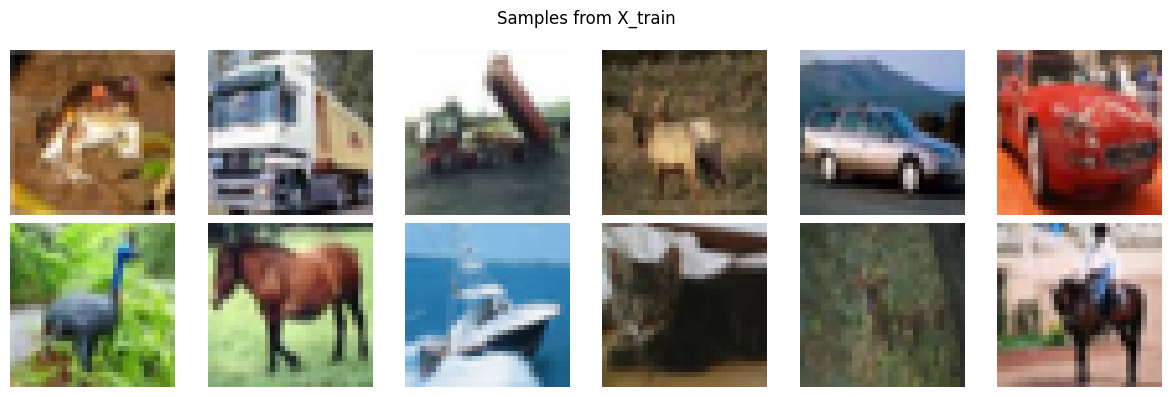

X_test: shape=(10000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~29.3 MB


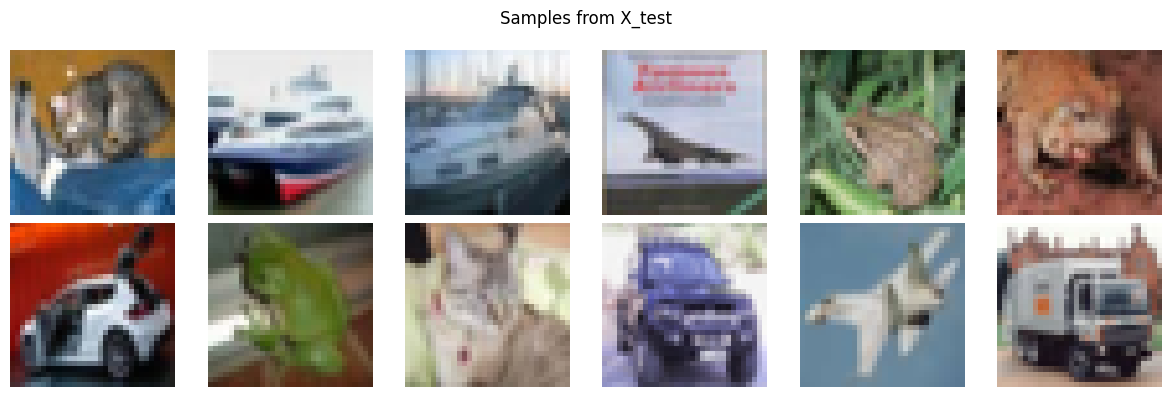

y_train: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
X_train (with labels): shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


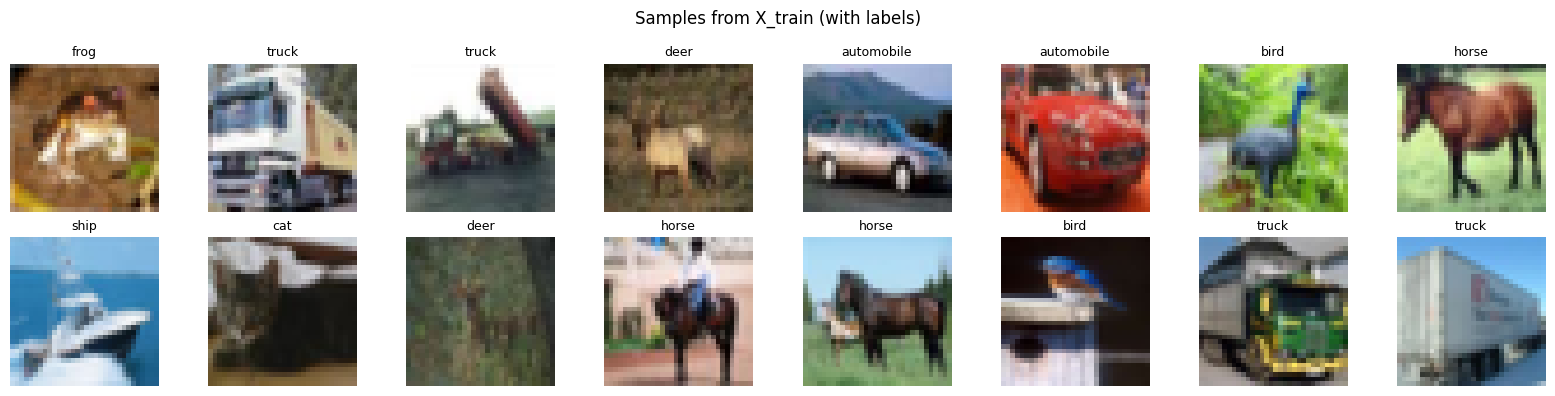

In [19]:
# ==== Peek into NPY contents (quick EDA) ====
import numpy as np, matplotlib.pyplot as plt, math

def peek_array(arr, name="array", n_show=12, cols=6, labels=None, label_map=None):
    """Print basic stats and (if RGB images) show a grid of samples."""
    flat_nbytes = arr.nbytes / 1024 / 1024
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min():.3f}, max={arr.max():.3f}, ~{flat_nbytes:.1f} MB")

    # If looks like images: (N, H, W, 3)
    is_rgb = (arr.ndim == 4 and arr.shape[-1] in (1,3) and arr.shape[1] <= 256 and arr.shape[2] <= 256)
    if is_rgb:
        n = min(n_show, arr.shape[0])
        rows = math.ceil(n / cols)
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(n):
            ax = plt.subplot(rows, cols, i+1)
            img = arr[i]
            # handle float arrays in [0,1]
            if arr.dtype.kind == "f":
                img = np.clip(img, 0.0, 1.0)
            ax.imshow(img.squeeze())
            ax.axis("off")
            if labels is not None:
                lab = labels[i]
                if label_map:
                    lab = label_map.get(int(lab), int(lab))
                ax.set_title(str(lab), fontsize=9)
        plt.suptitle(f"Samples from {name}", y=0.98)
        plt.tight_layout()
        plt.show()

# 1) 看原始 .npy 数组
peek_array(X_train, "X_train")
peek_array(X_test,  "X_test")

# 2) 看标签分布
unique, counts = np.unique(y_train, return_counts=True)
print("y_train:", dict(zip(unique.tolist(), counts.tolist())))
unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique.tolist(), counts.tolist())))

# 3) 展示若干训练样本（带标签名可选）
cifar10_label_to_text = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
                         5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
peek_array(X_train, "X_train (with labels)", n_show=16, cols=8,
           labels=y_train, label_map=cifar10_label_to_text)

# 如果你想单独查看任意 .npy 文件（例如新数据/中间结果），用：
# arr = np.load("path/to/any.npy")     # 或 np.load("...", mmap_mode='r')
# peek_array(arr, "any.npy")


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [14]:
# ==== CNN model factory (small & clear) ====
def make_cnn(filters_base=32, dropout=0.3, weight_decay=0.0):
    wd = keras.regularizers.l2(weight_decay) if weight_decay > 0 else None
    inputs = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(filters_base, 3, padding='same', use_bias=False, kernel_regularizer=wd)(inputs)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters_base*2, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv2D(filters_base*4, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# ==== One-pass training helper ====
def train_once(filters_base=32, dropout=0.3, weight_decay=0.0,
               lr=1e-3, batch_size=256, epochs=30, verbose=2):
    train_ds, val_ds, _ = make_datasets(batch_size)
    model = make_cnn(filters_base, dropout, weight_decay)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, min_delta=0.002, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5),
    ]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=verbose)
    elapsed = time.time() - t0
    val_acc = float(np.max(hist.history['val_accuracy']))
    return model, hist, val_acc, elapsed

# ==== Plot learning curves (acc) ====
def plot_curves(history, out_path='learning_curves_cnn.png', title='CNN Learning Curves'):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(title)
    plt.tight_layout(); plt.savefig(out_path, dpi=180)
    plt.close()

In [15]:
# ==== Train a baseline ====
baseline_model, baseline_hist, baseline_val_acc, baseline_time = train_once(
    filters_base=32, dropout=0.3, weight_decay=0.0,
    lr=1e-3, batch_size=256, epochs=30, verbose=2
)
print(f"[Baseline] val_acc={baseline_val_acc:.4f} | time={baseline_time/60:.1f} min | params={baseline_model.count_params()/1e6:.2f}M")

plot_curves(baseline_hist, out_path='learning_curves_cnn.png')

Epoch 1/30
176/176 - 42s - loss: 1.6029 - accuracy: 0.4270 - val_loss: 3.6564 - val_accuracy: 0.1034 - lr: 0.0010 - 42s/epoch - 240ms/step
Epoch 2/30
176/176 - 41s - loss: 1.3575 - accuracy: 0.5225 - val_loss: 2.6138 - val_accuracy: 0.2342 - lr: 0.0010 - 41s/epoch - 233ms/step
Epoch 3/30
176/176 - 41s - loss: 1.2646 - accuracy: 0.5543 - val_loss: 1.5411 - val_accuracy: 0.4310 - lr: 0.0010 - 41s/epoch - 233ms/step
Epoch 4/30
176/176 - 40s - loss: 1.2090 - accuracy: 0.5731 - val_loss: 1.3399 - val_accuracy: 0.5234 - lr: 0.0010 - 40s/epoch - 229ms/step
Epoch 5/30
176/176 - 41s - loss: 1.1564 - accuracy: 0.5933 - val_loss: 1.6684 - val_accuracy: 0.4564 - lr: 0.0010 - 41s/epoch - 231ms/step
Epoch 6/30
176/176 - 41s - loss: 1.1239 - accuracy: 0.6045 - val_loss: 1.4589 - val_accuracy: 0.4978 - lr: 0.0010 - 41s/epoch - 235ms/step
Epoch 7/30
176/176 - 41s - loss: 1.0948 - accuracy: 0.6191 - val_loss: 1.2291 - val_accuracy: 0.5502 - lr: 0.0010 - 41s/epoch - 231ms/step
Epoch 8/30
176/176 - 41s - 

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [16]:
# ==== Trials logging ====
TRIALS_LOG = 'trials_cnn.csv'
if not os.path.exists(TRIALS_LOG):
    with open(TRIALS_LOG, 'w', newline='') as f:
        csv.writer(f).writerow([
            'model','trial_id','hyperparams_json','epochs_run','best_val_acc',
            'best_val_loss','train_time_sec','hardware','timestamp'
        ])

def sample_space():
    hp = {
        'lr':          10**np.random.uniform(-4, -1.5),  # ~[1e-4, ~3e-2]
        'filters_base': random.choice([24, 32, 40]),
        'dropout':      random.choice([0.2, 0.35, 0.5]),
        'weight_decay': random.choice([1e-4, 5e-4, 1e-3]),
        'batch_size':   256,
    }
    return hp

class EpochPing(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        secs = time.time() - self._t0
        va = logs.get('val_accuracy', 0.0)
        print(f"  ↳ epoch {epoch+1} done in {secs:.1f}s | val_acc={va:.4f}", flush=True)

def run_trial(trial_id, epochs_max=40, verbose=0):
    hp = sample_space()
    print(f"[start trial {trial_id}] {hp}", flush=True)

    train_ds, val_ds, _ = make_datasets(hp['batch_size'])
    model = make_cnn(hp['filters_base'], hp['dropout'], hp['weight_decay'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5),
        EpochPing(),
    ]

    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs_max, verbose=verbose, callbacks=callbacks)
    elapsed = time.time() - t0

    best_va = float(np.max(hist.history['val_accuracy']))
    best_vl = float(np.min(hist.history['val_loss']))
    epochs_run = len(hist.history['val_accuracy'])
    hardware = tf.config.list_physical_devices()

    print(f"[end   trial {trial_id}] epochs_run={epochs_run} | best_val_acc={best_va:.4f} | time={elapsed/60:.1f} min", flush=True)

    with open(TRIALS_LOG, 'a', newline='') as f:
        csv.writer(f).writerow(['cnn', trial_id, json.dumps(hp), epochs_run, best_va, best_vl, int(elapsed), str(hardware), datetime.datetime.now().isoformat()])
    return best_va, hp


# ==== Smoke tuning: run a few trials first (e.g., 5). Later you can scale to 30. ====
best_va, best_hp = -1.0, None
for t in range(20):  # 修改为 30 可以做完整搜索
    va, hp = run_trial(trial_id=t, epochs_max=30, verbose=2)
    if va > best_va:
        best_va, best_hp = va, hp
    print(f"[trial {t}] val_acc={va:.4f} | hp={hp}")
print("Best so far:", best_va, best_hp)

# ==== Quick diagnostic plot: LR vs ValAcc (from trials_cnn.csv) ====
df_trials = pd.read_csv(TRIALS_LOG)
df_trials['hp'] = df_trials['hyperparams_json'].apply(json.loads)
df_trials['lr'] = df_trials['hp'].apply(lambda d: d['lr'])
plt.figure()
plt.scatter(df_trials['lr'], df_trials['best_val_acc'])
plt.xscale('log'); plt.xlabel('learning rate'); plt.ylabel('best val_acc')
plt.title('CNN Tuning: LR vs ValAcc'); plt.tight_layout()
plt.savefig('search_scatter_cnn_lr.png', dpi=180); plt.close()


[start trial 0] {'lr': 0.0008636748975005902, 'filters_base': 40, 'dropout': 0.2, 'weight_decay': 0.0001, 'batch_size': 256}
Epoch 1/30
  ↳ epoch 1 done in 56.0s | val_acc=0.1072
176/176 - 56s - loss: 1.6172 - accuracy: 0.4277 - val_loss: 3.4865 - val_accuracy: 0.1072 - lr: 8.6367e-04 - 56s/epoch - 318ms/step
Epoch 2/30
  ↳ epoch 2 done in 54.5s | val_acc=0.2304
176/176 - 55s - loss: 1.3653 - accuracy: 0.5291 - val_loss: 2.5790 - val_accuracy: 0.2304 - lr: 8.6367e-04 - 55s/epoch - 310ms/step
Epoch 3/30
  ↳ epoch 3 done in 55.4s | val_acc=0.4010
176/176 - 55s - loss: 1.2631 - accuracy: 0.5646 - val_loss: 1.7294 - val_accuracy: 0.4010 - lr: 8.6367e-04 - 55s/epoch - 315ms/step
Epoch 4/30
  ↳ epoch 4 done in 56.6s | val_acc=0.4942
176/176 - 57s - loss: 1.1986 - accuracy: 0.5870 - val_loss: 1.3598 - val_accuracy: 0.4942 - lr: 8.6367e-04 - 57s/epoch - 321ms/step
Epoch 5/30
  ↳ epoch 5 done in 56.9s | val_acc=0.4790
176/176 - 57s - loss: 1.1487 - accuracy: 0.6048 - val_loss: 1.6000 - val_accu

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [18]:
# ==== Pick best hyperparams from trials_cnn.csv ====
import json, pandas as pd
df = pd.read_csv('trials_cnn.csv')
best_idx = df['best_val_acc'].idxmax()
best_hp = json.loads(df.loc[best_idx, 'hyperparams_json'])
print("Best hyperparams:", best_hp, "| best_val_acc:", df.loc[best_idx, 'best_val_acc'])

# ==== Retrain from scratch with best hp (decoupled from tuning) ====
final_model, final_hist, final_val_acc, final_time = train_once(
    filters_base = best_hp['filters_base'],
    dropout      = best_hp['dropout'],
    weight_decay = best_hp['weight_decay'],
    lr           = best_hp['lr'],
    batch_size   = 256,
    epochs       = 30,
    verbose      = 2
)
print(f"[Final] val_acc={final_val_acc:.4f} | time={final_time/60:.1f} min | params={final_model.count_params()/1e6:.2f}M")

# ==== Test evaluation (rebuild test_ds to emphasize decoupling) ====
_, _, test_ds = make_datasets(best_hp['batch_size'])
test_loss, test_acc = final_model.evaluate(test_ds, verbose=0)
print(f"[TEST] acc={test_acc:.4f} | loss={test_loss:.4f}")

# ==== Confusion matrix on test set ====
y_prob = final_model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (CNN)'); plt.colorbar()
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
plt.savefig('confmat_cnn.png', dpi=180); plt.close()

# (Optional) Per-class report (appendix/logs)
print(classification_report(y_te, y_pred, digits=4))


Best hyperparams: {'lr': 0.003137951381652457, 'filters_base': 40, 'dropout': 0.35, 'weight_decay': 0.0001, 'batch_size': 64} | best_val_acc: 0.8040000200271606
Epoch 1/30
176/176 - 56s - loss: 1.5652 - accuracy: 0.4437 - val_loss: 3.7631 - val_accuracy: 0.1356 - lr: 0.0031 - 56s/epoch - 319ms/step
Epoch 2/30
176/176 - 54s - loss: 1.3193 - accuracy: 0.5425 - val_loss: 3.2555 - val_accuracy: 0.2162 - lr: 0.0031 - 54s/epoch - 308ms/step
Epoch 3/30
176/176 - 55s - loss: 1.2340 - accuracy: 0.5753 - val_loss: 1.8080 - val_accuracy: 0.3998 - lr: 0.0031 - 55s/epoch - 311ms/step
Epoch 4/30
176/176 - 55s - loss: 1.1700 - accuracy: 0.6020 - val_loss: 1.6801 - val_accuracy: 0.4468 - lr: 0.0031 - 55s/epoch - 311ms/step
Epoch 5/30
176/176 - 55s - loss: 1.1212 - accuracy: 0.6186 - val_loss: 1.6968 - val_accuracy: 0.4494 - lr: 0.0031 - 55s/epoch - 310ms/step
Epoch 6/30
176/176 - 55s - loss: 1.0832 - accuracy: 0.6397 - val_loss: 1.8058 - val_accuracy: 0.4608 - lr: 0.0031 - 55s/epoch - 310ms/step
Epoch